In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
a = []
with open("Total_rewards_eta=5.txt", "r") as f:
    a = f.read()

In [6]:
a = a.split("\n")[:-1]
a = [float(e) for e in a]

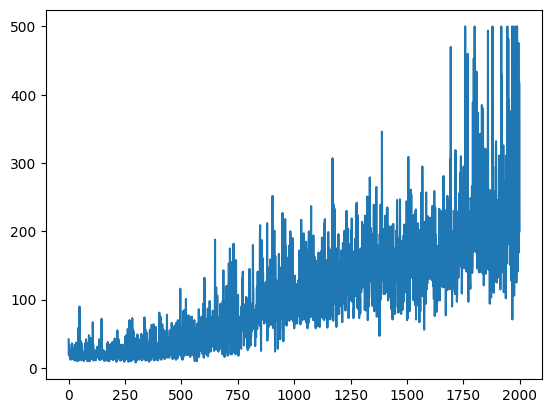

In [7]:
plt.plot(np.arange(len(a)), a)

In [8]:
b = [np.mean(a[i*100:(i+1)*100]) for i in range(0, int(len(a)/100))]

In [9]:
y_b = [[b[i]]*100 for i in np.arange(0, len(b))]
y_b = [item for l in y_b for item in l]

In [10]:
#calculate equation for trendline
x = np.arange(len(a))
z = np.polyfit(x, a, 1)
p = np.poly1d(z)

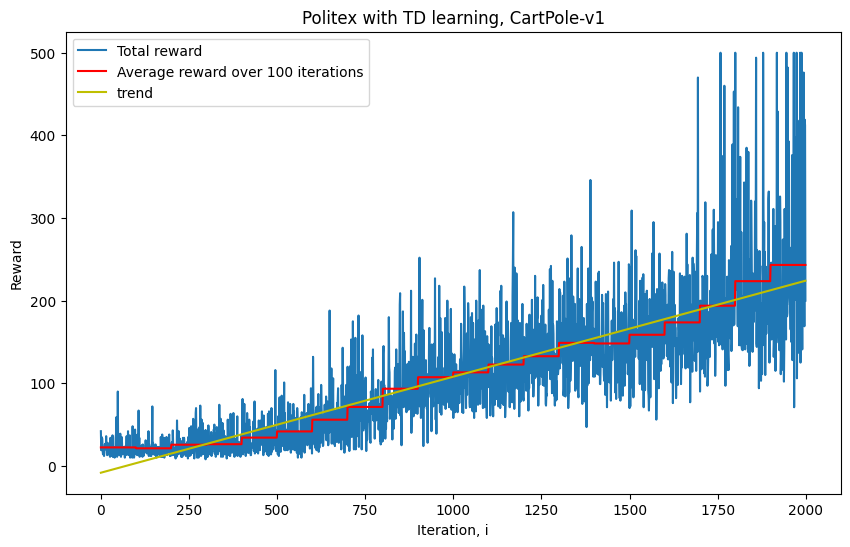

In [11]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(a)), a, label='Total reward')
plt.plot(np.arange(len(a)), y_b, 'r', label='Average reward over 100 iterations')
#add trendline to plot
plt.plot(x, p(x), 'y-', label='trend')
plt.xlabel('Iteration, i')
plt.ylabel('Reward')
plt.title('Politex with TD learning, CartPole-v1')
plt.legend()

In [49]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# !pip install -U gym
from scipy.special import softmax
import csv


def initi_Q(state_space, action_space, bin_size=30):
    
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.zeros(([bin_size] * state_space + [action_space]))
    return q_table, bins

def Discrete(obs, bins):
    obs_index = []
    for i in range(len(obs)): 
        obs_index.append(np.digitize(obs[i], bins[i]) - 1)
    return tuple(obs_index)

In [50]:
# Set hyperparameters
gamma = 0.995  # Discount factor
alpha = 0.1  # Learning rate
eta = 10.
tau = 1000 # Phase length
max_iterations = 1000  # Maximum number of iterations
epsilon = -0.01
batch_size = int(1024) 
print_every = 100
eval_every = 10

# Create the CartPole environment
env = gym.make('CartPole-v1')
env_eval = gym.make('CartPole-v1')

# Keep track of rewards and run time
rewards = []
av_rewards = []
episodes_lengths = []
av_phase_rewards = []
td_errors = []
list_r = []

state_dim =  env.observation_space.shape[0] # dimension of state space
action_dim =  env.action_space.n # number of possible actions

# Initialize the batch to empty, Q(s,a) and the accumulated reward to zeros
Z = []
Q, bins = initi_Q(state_dim, action_dim)
Q_hat = Q.copy()
total_reward = 0

# Algorithm: Politex
# Reset the environment and sample an initial state obs
obs, info = env.reset()
obs = Discrete(obs, bins)

for i in tqdm(range(max_iterations)):

    # Initialize policy
    policy = np.array(softmax(eta*Q_hat, axis=-1))
    total_reward = 0
    episode_length = 0
    
    phase_reward = []
    for t in range(tau):
        episode_length +=1
        # Execute current policy
        action = np.random.choice([0, 1], p=policy[obs])

        # Take action a and observe the reward and next state s'
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        next_obs = Discrete(next_obs, bins)

        # Store experience in replay buffer
        Z.append((obs, action, reward, next_obs, done))

        # Set current state to next state
        obs = next_obs

        total_reward += reward
        phase_reward.append(reward)

        if done:
            obs, info = env.reset()
            obs = Discrete(obs, bins)
            # Store episode reward and episode length
            episodes_lengths.append(episode_length) # TODO this is basically the total_rewards-1 since reward is +1 for each time step, do we need it?
            rewards.append(total_reward)
            # reinitilize total reward for next episode
            total_reward = 0
            episode_length = 0 
            phase_reward.append(0.)

    # eta -= 0.0005 # TODO why do we do this?
    av_phase_rewards.append(np.mean(phase_reward))

    # Sample a random batch of experiences from Z
    batch = random.sample(Z, min(batch_size, len(Z)))

    # Compute Q-values using data in Z  
    # TODO 1) Here the problem was that alpha was too small. 
    # We should also think that making more steps with the same tuple (s,a,r...) can be beneficial, so we might rethink the loop below. 
    # I am not sure anyway how to change it, we need to try. 
    # But for sure if alpha is too small and you dont do more steps on the same state-actions then Q changes are too small for each (s,a) pair.
    # TODO 2) before you were using an argmax over Q wich is good for Q learning but here we just try to estimate Q_\pi for 
    # policy \pi. Therefore the idea is to compute TD
    error = []
    for obs_batch, action_batch, reward_batch, next_obs_batch, done_batch in batch:
        Q_next_obs = [Q[next_obs_batch][a] for a in range(env.action_space.n)]
        # V_next_obs = max(Q_next_obs) # TODO this should be theoretically wrong but works well in practice 
        V_next_obs = Q_next_obs @ policy[next_obs]
        # a_next = np.random.choice(actions, p[:, next_obs]) !TRY this (SARSA update)
        # Calculate TD error
        td_error = reward_batch + gamma * V_next_obs - Q[obs_batch][action_batch]
        # td = .. q[next_obs, a_next] - q[obs, a] !TRY this (SARSA update)
        error.append(td_error)
        # Update Q-value for current state-action pair
        Q[obs_batch][action_batch] += alpha * td_error
        
    td_errors.append(np.mean(error))

    Q_hat = (i+1) * Q_hat / (i+2) + Q / (i+2) # TODO check this is the right fomula for cumulative average
    # sum_q_o_a += q_o_a
    # logits = sum_q_o_a.T.copy()

    # Print progress every 100 iterations
    rewards.append(total_reward)
    if (i + 1) % print_every == 0:
        av_rewards = np.mean(np.array(rewards[-100:]))
        print(f'Iteration {i + 1}/{max_iterations} | Last total reward: {total_reward} | '
              f'Average reward in last 100 episodes: {av_rewards} | Last episode length: {episodes_lengths[-1]}')
        
    if (i + 1) % eval_every == 0:
        done = False 
        eval_obs, eval_info = env_eval.reset()
        sum_r = 0
        
        while not done:
            eval_obs = Discrete(eval_obs, bins)
            eval_a = np.random.choice([0, 1], p=policy[eval_obs])
            eval_obs, r, terminated, truncated, _ = env_eval.step(eval_a)
            done = terminated or truncated
            sum_r += r
            
        list_r.append(sum_r)

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 100/1000 | Last total reward: 30.0 | Average reward in last 100 episodes: 60.41 | Last episode length: 33
Iteration 200/1000 | Last total reward: 8.0 | Average reward in last 100 episodes: 54.51 | Last episode length: 48
Iteration 300/1000 | Last total reward: 47.0 | Average reward in last 100 episodes: 67.1 | Last episode length: 18
Iteration 400/1000 | Last total reward: 49.0 | Average reward in last 100 episodes: 69.08 | Last episode length: 78
Iteration 500/1000 | Last total reward: 0 | Average reward in last 100 episodes: 69.97 | Last episode length: 80
Iteration 600/1000 | Last total reward: 38.0 | Average reward in last 100 episodes: 67.88 | Last episode length: 55
Iteration 700/1000 | Last total reward: 18.0 | Average reward in last 100 episodes: 67.29 | Last episode length: 85
Iteration 800/1000 | Last total reward: 28.0 | Average reward in last 100 episodes: 65.56 | Last episode length: 103
Iteration 900/1000 | Last total reward: 52.0 | Average reward in last 100 ep

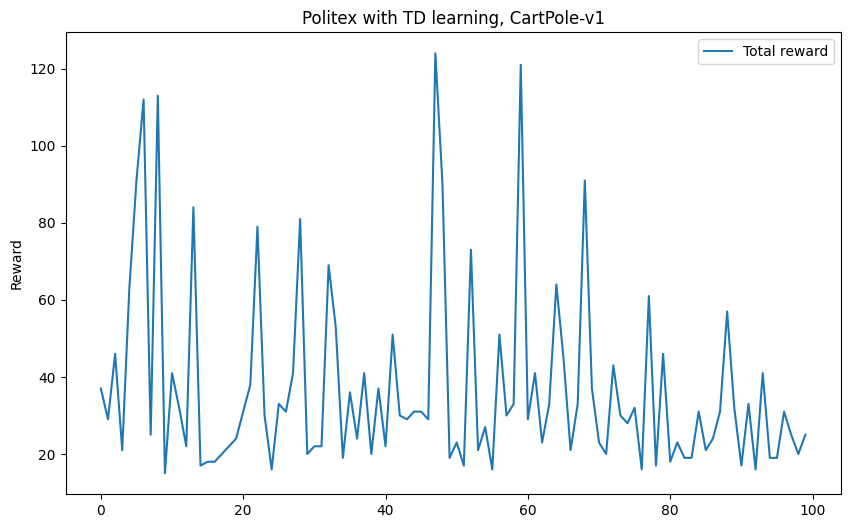

In [46]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(list_r)), list_r, label='Total reward')
plt.ylabel('Reward')
plt.title('Politex with TD learning, CartPole-v1')
plt.legend()

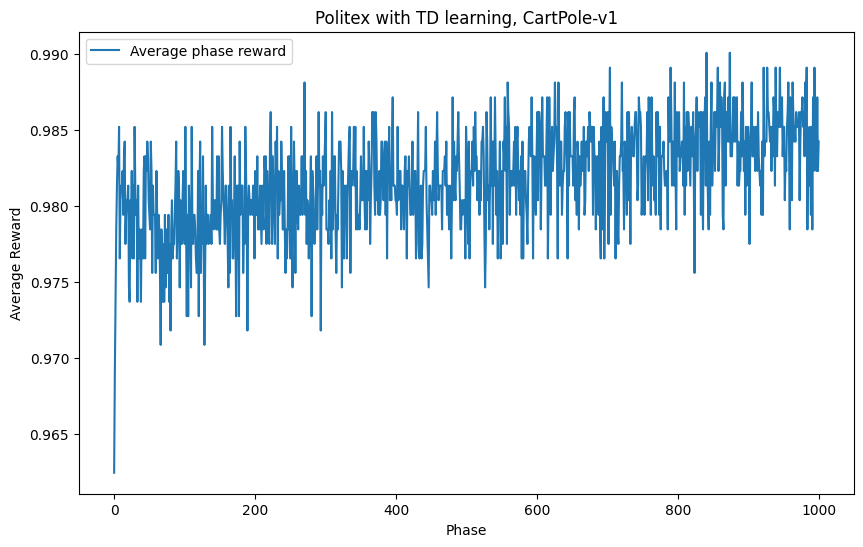

In [39]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(max_iterations), av_phase_rewards, label='Average phase reward')
plt.xlabel('Phase')
plt.ylabel('Average Reward')
plt.title('Politex with TD learning, CartPole-v1')
plt.legend()

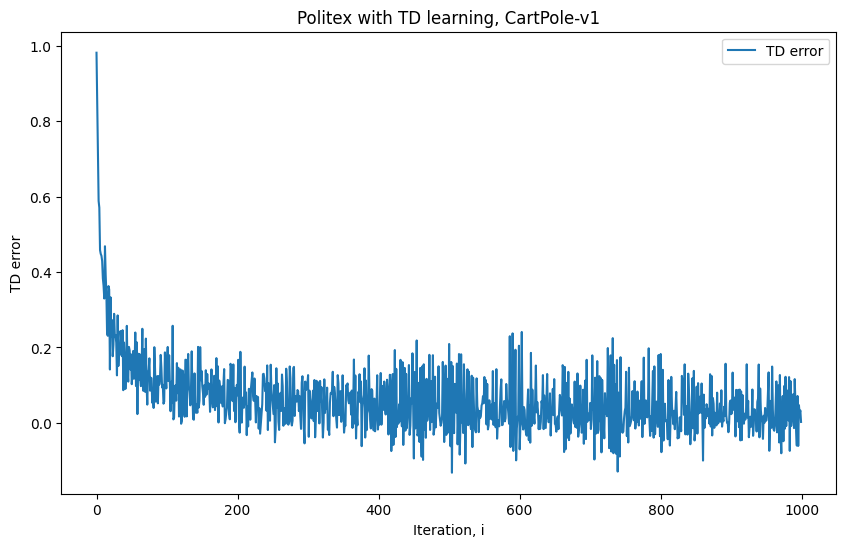

In [40]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(td_errors)), td_errors, label='TD error')
plt.xlabel('Iteration, i')
plt.ylabel('TD error')
plt.title('Politex with TD learning, CartPole-v1')
plt.legend()